In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

%load_ext autoreload
%matplotlib inline

module_path = os.path.abspath(os.path.join('./syn_ant_modules'))
if module_path not in sys.path:
    sys.path.append(module_path)
import model_dataset as dataset 
import model_functions_PhaseI as functions
import model_morphology as morpho
import model_testing_PhaseI as test 
import model_training_PhaseI as train

torch.manual_seed(28)

In [2]:
word_pairs_df = pd.read_excel('/Users/wesleytatum/Desktop/post_doc/BETO/BETO2020/Ant_Syn_Scraping/data/new_syn_ant_list.xlsx')
word_pairs_df = word_pairs_df.drop('Unnamed: 0', axis = 1)
word_pairs_df

,word 1,word 2,label
0,infinite,bounded,2
1,infinite,brief,2
2,infinite,calculable,0
3,infinite,ceasing,2
4,infinite,ending,2
...,...,...,...
14227,charm,fascinate,1
14228,charm,magical spell,1
14229,charm,appealingness,1
14230,charm,enchant,1


In [3]:
word_pairs_df['label'].value_counts()

1    6534
0    4696
2    3002
Name: label, dtype: int64

In [4]:
indices = pd.DataFrame(columns = ['index', 'word'])

index = 0
bad_indexs = []

pbar = tqdm(total = len(word_pairs_df), position = 0)

string = 'string'

for i in range(len(word_pairs_df)):
    
    word1 = word_pairs_df['word 1'].iloc[i]
    word2 = word_pairs_df['word 2'].iloc[i]
    
    if len(indices[indices.word.isin([word1])]) == 0:
        if type(word1) == type(string):
            indices.loc[index] = pd.Series({'index':index, 'word':word1})
            index+=1
        else:
            bad_indexs.append(i)
    else:
        pass
    
    if len(indices[indices.word.isin([word2])]) == 0:
        if type(word2) == type(string):
            indices.loc[index] = pd.Series({'index':index, 'word':word2})
            index+=1
        else:
            bad_indexs.append(i)
    else:
        pass
    
    pbar.update()
    
for idx in bad_indexs:
    print(word_pairs_df.iloc[idx])

100%|██████████| 14232/14232 [01:00<00:00, 401.48it/s]

In [5]:
word_pairs_df = word_pairs_df.drop(bad_indexs)
word_pairs_df = word_pairs_df.reset_index(drop = True)
word_pairs_df.to_excel('/Users/wesleytatum/Desktop/post_doc/BETO/BETO2020/Ant_Syn_Scraping/data/new_syn_ant_list.xlsx')

In [6]:
indices = indices.drop_duplicates(subset = ['word'])
indices = indices.dropna()
indices = indices.reset_index(drop = True)
indices

,index,word
0,0,infinite
1,1,bounded
2,2,brief
3,3,calculable
4,4,ceasing
...,...,...
9038,9038,magical spell
9039,9039,appealingness
9040,9040,enchant
9041,9041,embodying


In [7]:
indices.to_json('/Users/wesleytatum/Desktop/post_doc/data/syn_ant_index.json')

In [5]:
indices = pd.read_json('/Users/wesleytatum/Desktop/post_doc/data/syn_ant_index.json')

In [9]:
#if new train-test-split is needed

%autoreload

X = word_pairs_df[['word 1', 'word 2']]
Y = word_pairs_df['label']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)

train_save = '/Users/wesleytatum/Desktop/post_doc/data/nn_datasets/train.json'
test_save = '/Users/wesleytatum/Desktop/post_doc/data/nn_datasets/test.json'

train_set = dataset.DistillerDataset(x_train, y_train, indices, path = train_save)
test_set = dataset.DistillerDataset(x_test, y_test, indices, path = test_save)

100%|██████████| 2847/2847 [00:29<00:00, 183.58it/s]s]

In [11]:
len(test_set)

2847

In [8]:
#if existing train-test-split is alright

%autoreload

train_path ='/Users/wesleytatum/Desktop/post_doc/data/nn_datasets/train.json'
test_path = '/Users/wesleytatum/Desktop/post_doc/data/nn_datasets/test.json'

wp = 'dummy_variable'
lbs = 'dummy_variable'

train_set = dataset.DistillerDataset(word_pairs = wp, labels = lbs,
                                     indices = indices, path = train_path)
test_set = dataset.DistillerDataset(word_pairs = wp, labels = lbs,
                                    indices = indices, path = test_path)

In [9]:
train_set[0]

(tensor([1134, 1052]), tensor([2]))

In [10]:
#Hyper parameters
num_epochs = 30
batch_size = 50
learning_rate = 5e-4

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True)

In [17]:
%autoreload

vocab_length = len(indices)+1 #+1 avoids indexing error
print(f'vocabulary length = {vocab_length}')

# Instantiate NN model. 'in_dims' = dimensions of embeddings in 'common'
model = morpho.Phase_I_NN(in_dims = 200,
                          vocab_length = vocab_length,
                          common = None,
                          w2v_model = None).to(device)
model.apply(functions.init_weights)

#define the optimizer
optimizer = torch.optim.AdamW(params = model.parameters(),
                              lr = learning_rate,
                              amsgrad = False)

vocabulary length = 9044


In [18]:
%autoreload

#empty list to hold loss per epoch
train_epoch_losses = []
syn_train_epoch_losses = []
ant_train_epoch_losses = []

syn_train_epoch_accuracies = []
ant_train_epoch_accuracies = []
irrel_train_epoch_accuracies = []

test_epoch_losses = []
syn_test_epoch_losses = []
ant_test_epoch_losses = []

syn_test_epoch_accuracies = []
ant_test_epoch_accuracies = []
irrel_test_epoch_accuracies = []

pbar = tqdm(total = num_epochs, position = 0)

for epoch in range(num_epochs):
    
    train_epoch_loss, syn_train_epoch_loss, ant_train_epoch_loss, Lm_train_epoch_loss, train_syn_epoch_acc, train_ant_epoch_acc, train_irrel_epoch_acc = train.Phase_I_train_model(model = model, training_data_set = train_loader, optimizer = optimizer)
        
    train_epoch_losses.append(train_epoch_loss)
    syn_train_epoch_losses.append(syn_train_epoch_loss)
    ant_train_epoch_losses.append(ant_train_epoch_loss)
    syn_train_epoch_accuracies.append(train_syn_epoch_acc)
    ant_train_epoch_accuracies.append(train_ant_epoch_acc)
    irrel_train_epoch_accuracies.append(train_irrel_epoch_acc)
   
    test_epoch_loss, syn_test_epoch_loss, ant_test_epoch_loss, Lm_test_epoch_loss, syn_epoch_acc, ant_epoch_acc, irrel_epoch_acc, syn_true, syn_predictions, ant_true, ant_predictions = test.Phase_I_eval_model(model = model, testing_data_set = test_loader, optimizer = optimizer)
        
    test_epoch_losses.append(test_epoch_loss)
    syn_test_epoch_losses.append(syn_test_epoch_loss)
    ant_test_epoch_losses.append(ant_test_epoch_loss)
    
    syn_test_epoch_accuracies.append(syn_epoch_acc)
    ant_test_epoch_accuracies.append(ant_epoch_acc)
    irrel_test_epoch_accuracies.append(irrel_epoch_acc)

    pbar.update()

100%|██████████| 30/30 [10:12<00:00, 21.25s/it]

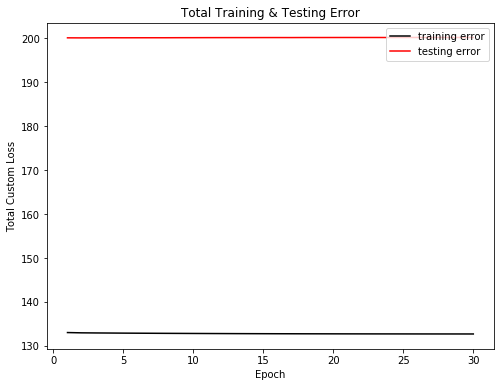

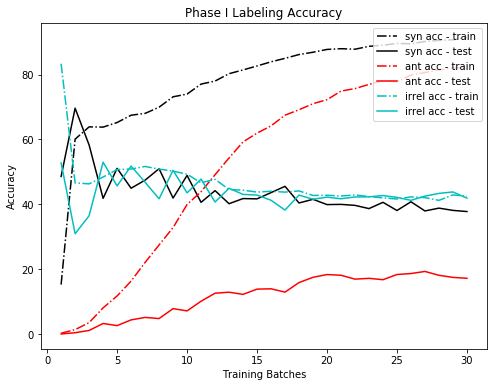

In [19]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('Total Custom Loss')
plt.show()

fig, ax = plt.subplots(figsize = (8,6))
plt.plot(epochs, syn_train_epoch_accuracies, c = 'k', linestyle = '-.', label = 'syn acc - train')
plt.plot(epochs, syn_test_epoch_accuracies, c = 'k', label = 'syn acc - test')
plt.plot(epochs, ant_train_epoch_accuracies, c = 'r', linestyle = '-.', label = 'ant acc - train')
plt.plot(epochs, ant_test_epoch_accuracies, c = 'r', label = 'ant acc - test')
plt.plot(epochs, irrel_train_epoch_accuracies, c = 'c', linestyle = '-.', label = 'irrel acc - train')
plt.plot(epochs, irrel_test_epoch_accuracies, c = 'c', label = 'irrel acc - test')
plt.legend(loc = 'upper right')
plt.title("Phase I Labeling Accuracy")
ax.set_xlabel('Training Batches')
ax.set_ylabel('Accuracy')
plt.show()

In [39]:
#thresholding the predicted values to be compared to the labels
syn_predictions = list(map(lambda x:1 if x >= 0.8 else x, syn_predictions))
syn_predictions = list(map(lambda x:0 if -0.8 < x < 0.8 else x, syn_predictions))
syn_predictions = list(map(lambda x:-1 if x <= -0.8 else x, syn_predictions))

ant_predictions = list(map(lambda x:1 if x >= 0.8 else x, ant_predictions))
ant_predictions = list(map(lambda x:0 if -0.8 < x < 0.8 else x, ant_predictions))
ant_predictions = list(map(lambda x:-1 if x <= -0.8 else x, ant_predictions))


#synonymy confusion matrix
syn_matrix = confusion_matrix(syn_true, syn_predictions)

#antonymy confusion matrix
ant_matrix = confusion_matrix(ant_true, ant_predictions)

In [40]:
syn_matrix

array([[1473,   65],
       [1255,   54]])

In [41]:
ant_matrix

array([[2237,    1],
       [ 609,    0]])